# Task 2: feature selection

### **Notebook Initialization**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [56]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("Blues")
colors = sns.color_palette()

### **T2.1. EDA**
Explore the data to generate summary statistics and plots that help the reader understand the data, with a focus on information relevant to the classification task.

#### T2.1.1. Load and Verify Data

In [58]:
df = pd.read_csv('data-2.csv.gz', compression='gzip')
print(f"Full dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
print(f"Columns: {df.columns.tolist()[:5]}") # print only first 5 columns
print(f"\nFirst few rows:")
print(df.head(3))

Full dataset shape: (683, 11191)
Memory usage: 58.3 MB
Columns: ['label', 'unit_0000_bin_0', 'unit_0001_bin_0', 'unit_0002_bin_0', 'unit_0003_bin_0']

First few rows:
   label  unit_0000_bin_0  unit_0001_bin_0  unit_0002_bin_0  unit_0003_bin_0  \
0      1                1                0                0                2   
1      0                4                8                0                3   
2      1                2                5                0                2   

   unit_0004_bin_0  unit_0005_bin_0  unit_0006_bin_0  unit_0007_bin_0  \
0                6                0                0                1   
1                9               13                6                3   
2                7                1                0                0   

   unit_0008_bin_0  ...  unit_2228_bin_4  unit_2229_bin_4  unit_2230_bin_4  \
0                0  ...                0                0                0   
1                0  ...                0                0      

In [ ]:
# Check dimensions and feature structure
X = df.drop('label', axis=1)
y = df['label']

n_samples = X.shape[0]
n_features = X.shape[1]

def parse_feature(col): # Extract neuron ID and time bin from feature name
    parts = col.split('_')
    return int(parts[1]), int(parts[3])  # (neuron_id, time_bin)

feature_cols = X.columns.tolist()
feature_info = [parse_feature(col) for col in feature_cols]
neuron_ids_array = np.array([f[0] for f in feature_info])
time_bins_array = np.array([f[1] for f in feature_info])

n_neurons = len(np.unique(neuron_ids_array))
n_bins = len(np.unique(time_bins_array))

print(f"\nDimensions:")
print(f"  Trials (n): {n_samples}")
print(f"  Features (p): {n_features}")
print(f"  Neurons: {n_neurons}")
print(f"  Time bins: {n_bins}")
print(f"  p/n ratio: {n_features/n_samples:.2f}")

print(f"\nFeature Structure:")
print(f"  - {n_neurons} neurons × {n_bins} time bins = {n_neurons * n_bins} total features")
print(f"  - Each time bin: 100ms (covering 0-500ms post-stimulus)")


Dimensions:
  Trials (n): 683
  Features (p): 11190
  Neurons: 2238
  Time bins: 5
  p/n ratio: 16.38

Feature Structure:
  - 2238 neurons × 5 time bins = 11190 total features
  - Each time bin: 100ms (covering 0-500ms post-stimulus)


In [60]:
# Check for missing values
missing = df.isnull().sum().sum()
print(f"\nMissing values: {missing}")


Missing values: 0


In [61]:
# Verify label encoding
print(f"\nLabel distribution:")
print(y.value_counts().sort_index())


Label distribution:
label
0    208
1    475
Name: count, dtype: int64


#### T2.1.2. Dimensionality Assessment

In [62]:
# Calculate sparsity (proportion of zeros)
total_values = X.size
zero_count = (X == 0).sum().sum()
sparsity = (zero_count / total_values) * 100

print(f"Sparsity: {sparsity:.2f}% of values are zero")

Sparsity: 74.03% of values are zero


In [75]:
# Sparsity per feature
feature_sparsity = (X == 0).sum(axis=0) / n_samples * 100
print(f"\nFeature-level sparsity:")
print(f"  Mean: {feature_sparsity.mean():.2f}%")
print(f"  Median: {feature_sparsity.median():.2f}%")
print(f"  Min: {feature_sparsity.min():.2f}%")
print(f"  Max: {feature_sparsity.max():.2f}%")


Feature-level sparsity:
  Mean: 74.03%
  Median: 74.67%
  Min: 1.32%
  Max: 100.00%


In [76]:
# Features with 100% zeros
completely_silent = (feature_sparsity == 100).sum()
print(f"\nCompletely silent features (100% zeros): {completely_silent}")


Completely silent features (100% zeros): 536


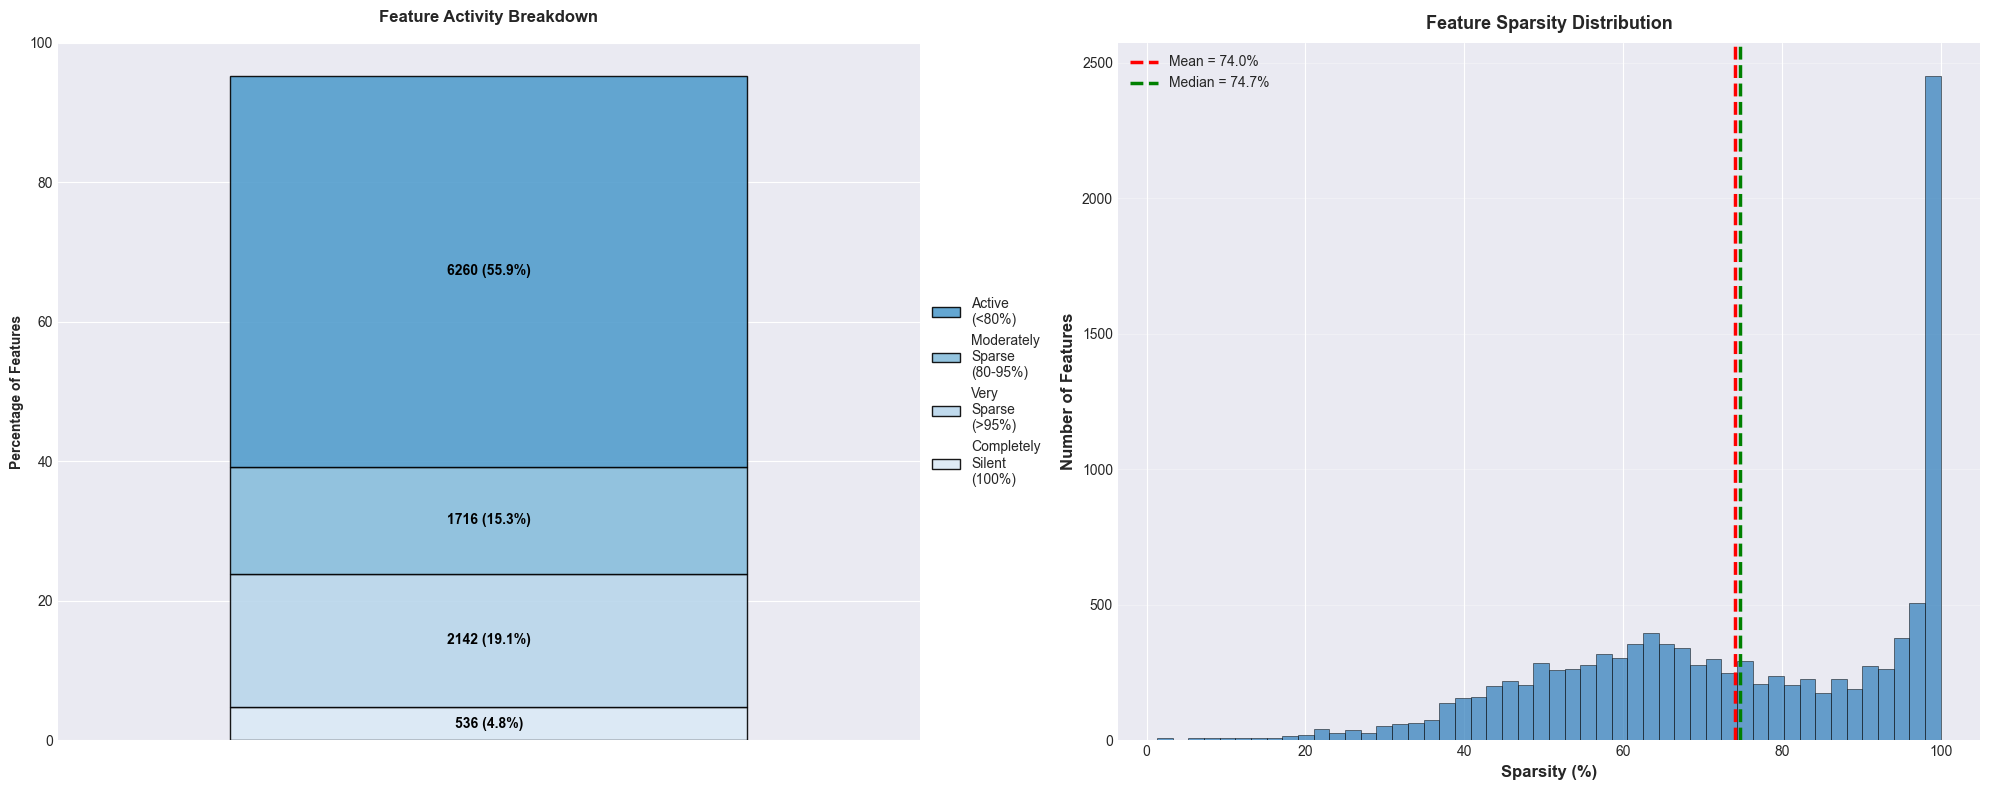

In [77]:
# Activity breakdown and sparsity distribution visualizations
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

active = (feature_sparsity < 80).sum()
moderately_sparse = ((feature_sparsity >= 80) & (feature_sparsity <= 95)).sum()
very_sparse = ((feature_sparsity > 95) & (feature_sparsity < 100)).sum()

# Left plot
ax = axes[0]
feature_categories = ['Completely\nSilent\n(100%)', 'Very\nSparse\n(>95%)', 'Moderately\nSparse\n(80-95%)', 'Active\n(<80%)']
feature_counts = [completely_silent, very_sparse - completely_silent, moderately_sparse, active]
feature_percentages = [c/n_features*100 for c in feature_counts]

bottom = 0
for count, pct, label in zip(feature_counts, feature_percentages, feature_categories):
    ax.bar(0, pct, bottom=bottom, alpha=0.9, edgecolor='black', linewidth=1, label=label, width=0.6)
    
    if pct > 3:
        ax.text(0, bottom + pct/2, f'{count} ({pct:.1f}%)', ha='center', va='center', fontweight='bold', color='black')
    bottom += pct

ax.set_ylabel('Percentage of Features', fontweight='bold')
ax.set_title('Feature Activity Breakdown', fontweight='bold', pad=15)
ax.set_ylim(0, 100)
ax.set_xlim(-0.5, 0.5)
ax.set_xticks([])
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), loc='center left', bbox_to_anchor=(1, 0.5))

# Right plot
ax = axes[1]
sparsity_values = feature_sparsity.values
ax.hist(sparsity_values, bins=50, alpha=0.7, edgecolor='black', linewidth=0.5, color=colors[4])
ax.axvline(sparsity_values.mean(), color='red', linestyle='--', linewidth=2.5, label=f'Mean = {sparsity_values.mean():.1f}%')
ax.axvline(np.median(sparsity_values), color='green', linestyle='--', linewidth=2.5, label=f'Median = {np.median(sparsity_values):.1f}%')

ax.set_xlabel('Sparsity (%)', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Features', fontsize=12, fontweight='bold')
ax.set_title('Feature Sparsity Distribution', fontsize=13, fontweight='bold', pad=10)
ax.legend(fontsize=10, loc='upper left')
ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

#### T2.1.3. Class Balance Analysis

In [66]:
class_counts = y.value_counts().sort_index()
class_props = y.value_counts(normalize=True).sort_index() * 100

print("Class distribution:")
for cls in [0, 1]:
    label_name = "Left" if cls == 0 else "Right"
    print(f"  Class {cls} ({label_name}): {class_counts[cls]} ({class_props[cls]:.1f}%)")

imbalance_ratio = class_counts.max() / class_counts.min()
print(f"\nImbalance ratio: {imbalance_ratio:.2f}")

Class distribution:
  Class 0 (Left): 208 (30.5%)
  Class 1 (Right): 475 (69.5%)

Imbalance ratio: 2.28


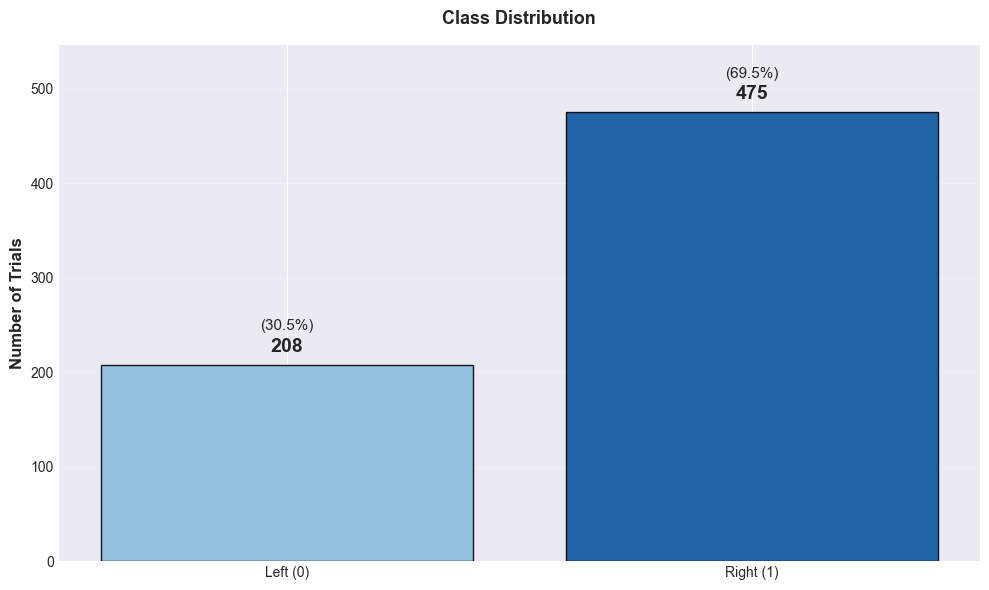

In [ ]:
# Class Balance Visualization
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

bars = ax.bar(['Left (0)', 'Right (1)'], class_counts.values, color=[colors[2], colors[5]] , alpha=0.9, edgecolor='black', linewidth=1)

ax.set_ylabel('Number of Trials', fontsize=12, fontweight='bold')
ax.set_title('Class Distribution', fontsize=13, fontweight='bold', pad=15)
ax.set_ylim(0, max(class_counts.values) * 1.15)

ax.grid(axis='y', alpha=0.3)

for i, (bar, count, prop) in enumerate(zip(bars, class_counts.values, class_props.values)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + max(class_counts.values) * 0.02, f'{count}', ha='center', va='bottom', fontweight='bold', fontsize=14)
    ax.text(bar.get_x() + bar.get_width()/2., height + max(class_counts.values) * 0.07, f'({prop:.1f}%)', ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()

#### T2.1.4. Feature-Level Statistics

In [68]:
# Overall statistics
X_nonzero = X[X > 0]
print("Spike count distribution:")
print(f"  All values - Mean: {X.values.mean():.3f}, Std: {X.values.std():.3f}")
print(f"  Non-zero only - Mean: {X_nonzero.values.mean():.3f}, Std: {X_nonzero.values.std():.3f}")
print(f"  Median: {np.median(X.values):.3f}")
print(f"  Max: {X.values.max():.3f}")
print(f"  Min: {X.values.min():.3f}")

Spike count distribution:
  All values - Mean: 0.419, Std: 0.905
  Non-zero only - Mean: nan, Std: nan
  Median: 0.000
  Max: 29.000
  Min: 0.000


In [69]:
# Variance analysis
feature_variances = X.var(axis=0)
print(f"\nFeature variance distribution:")
print(f"  Mean: {feature_variances.mean():.3f}")
print(f"  Median: {feature_variances.median():.3f}")
print(f"  Min: {feature_variances.min():.3f}")
print(f"  Max: {feature_variances.max():.3f}")
print(f"  Features with zero variance: {(feature_variances == 0).sum()}")


Feature variance distribution:
  Mean: 0.611
  Median: 0.406
  Min: 0.000
  Max: 19.618
  Features with zero variance: 536


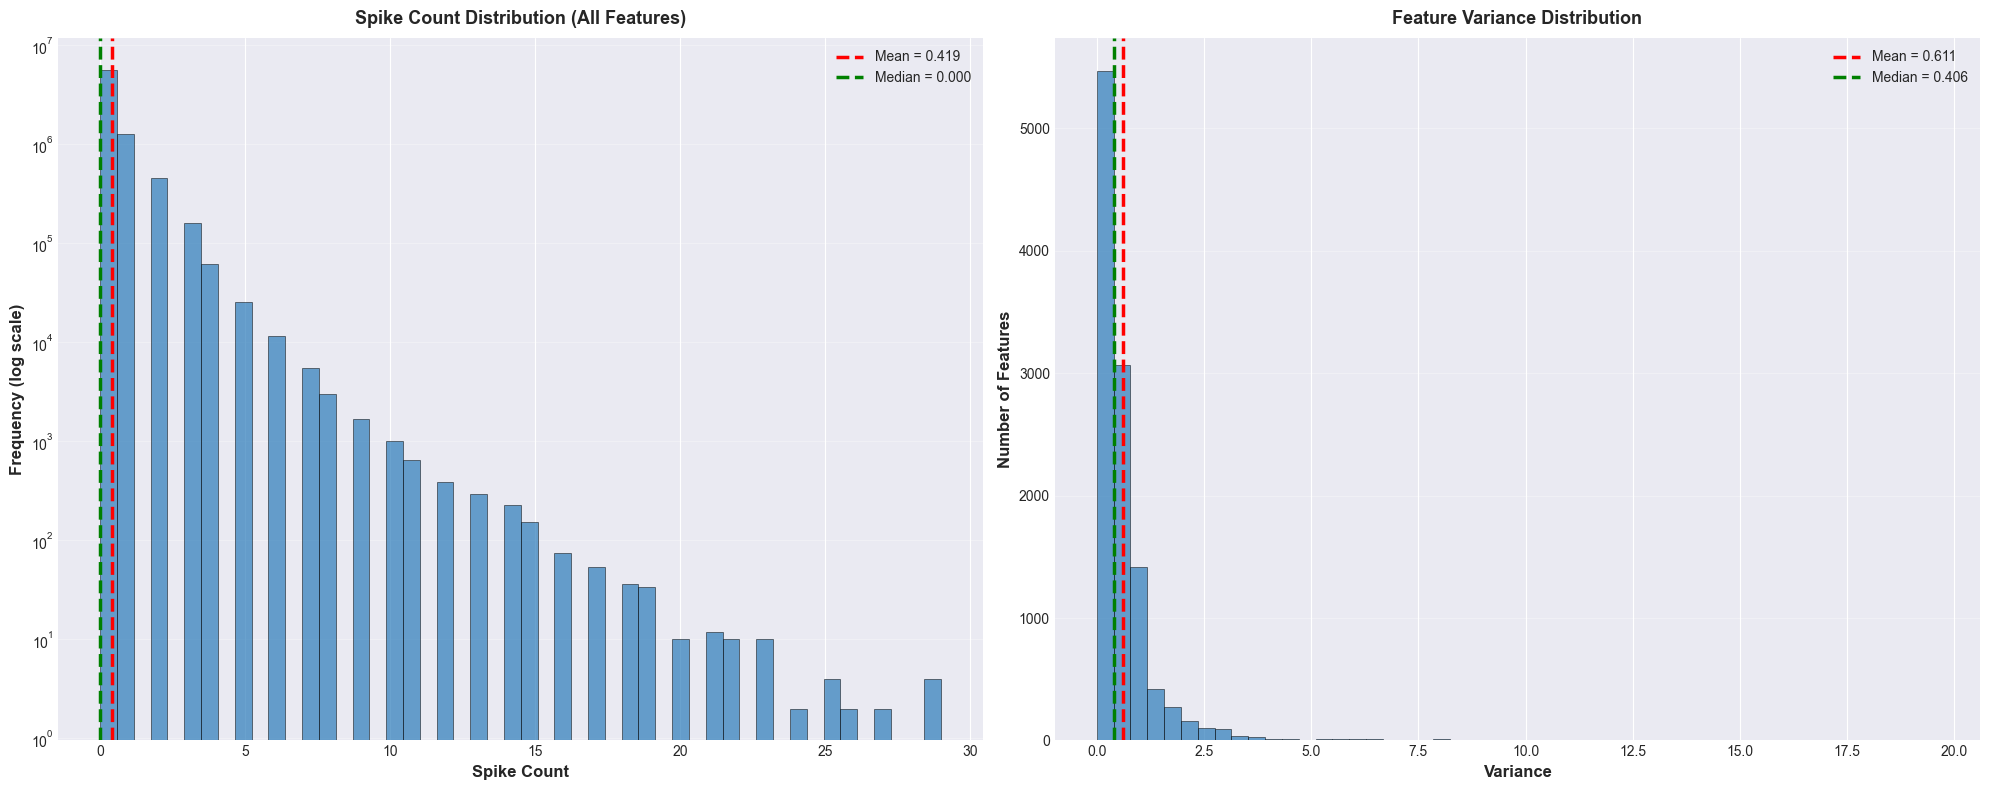

In [ ]:
# Spike count and variance visualization
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Left plot
ax = axes[0]
spike_counts_flat = X.values.flatten()
sparsity_flat = (spike_counts_flat == 0).sum() / len(spike_counts_flat) * 100

ax.hist(spike_counts_flat, bins=50, color=colors[4], alpha=0.7, edgecolor='black', linewidth=0.5)
ax.axvline(spike_counts_flat.mean(), color='red', linestyle='--', linewidth=2.5, label=f'Mean = {spike_counts_flat.mean():.3f}')
ax.axvline(np.median(spike_counts_flat), color='green', linestyle='--', linewidth=2.5, label=f'Median = {np.median(spike_counts_flat):.3f}')

ax.set_xlabel('Spike Count', fontsize=12, fontweight='bold')
ax.set_ylabel('Frequency (log scale)', fontsize=12, fontweight='bold')
ax.set_yscale('log')
ax.set_title('Spike Count Distribution (All Features)', fontsize=13, fontweight='bold', pad=10)
ax.legend(fontsize=10, loc='upper right')
ax.grid(alpha=0.3, axis='y')

# Right plot
ax = axes[1]
variance_values = feature_variances.values
ax.hist(variance_values, bins=50, color=colors[4], alpha=0.7, edgecolor='black', linewidth=0.5)
ax.axvline(variance_values.mean(), color='red', linestyle='--', linewidth=2.5, label=f'Mean = {variance_values.mean():.3f}')
ax.axvline(np.median(variance_values), color='green', linestyle='--', linewidth=2.5, label=f'Median = {np.median(variance_values):.3f}')

ax.set_xlabel('Variance', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Features', fontsize=12, fontweight='bold')
ax.set_title('Feature Variance Distribution', fontsize=13, fontweight='bold', pad=10)
ax.legend(fontsize=10, loc='upper right')
ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [72]:
# Top 20 variable features
top_k = 20
top_var_indices = feature_variances.nlargest(top_k).index
top_var_df = pd.DataFrame({
    'Feature': top_var_indices,
    'Neuron': [int(f.split('_')[1]) for f in top_var_indices],
    'Time_Bin': [int(f.split('_')[3]) for f in top_var_indices],
    'Variance': feature_variances[top_var_indices].values
})

print(f"\nTop {top_k} most variable features:")
print(top_var_df.to_string(index=False))


Top 20 most variable features:
        Feature  Neuron  Time_Bin  Variance
unit_0955_bin_4     955         4 19.617875
unit_2074_bin_4    2074         4 19.617875
unit_0920_bin_4     920         4 18.159693
unit_2039_bin_4    2039         4 18.159693
unit_0955_bin_1     955         1 17.500655
unit_2074_bin_1    2074         1 17.500655
unit_0955_bin_3     955         3 15.893831
unit_2074_bin_3    2074         3 15.893831
unit_0920_bin_3     920         3 14.951259
unit_2039_bin_3    2039         3 14.951259
unit_0955_bin_2     955         2 14.299511
unit_2074_bin_2    2074         2 14.299511
unit_0920_bin_1     920         1 12.759338
unit_2039_bin_1    2039         1 12.759338
unit_0686_bin_1     686         1 11.743086
unit_1805_bin_1    1805         1 11.743086
unit_0004_bin_3       4         3 11.657772
unit_1123_bin_3    1123         3 11.657772
unit_0005_bin_1       5         1 11.185807
unit_1124_bin_1    1124         1 11.185807


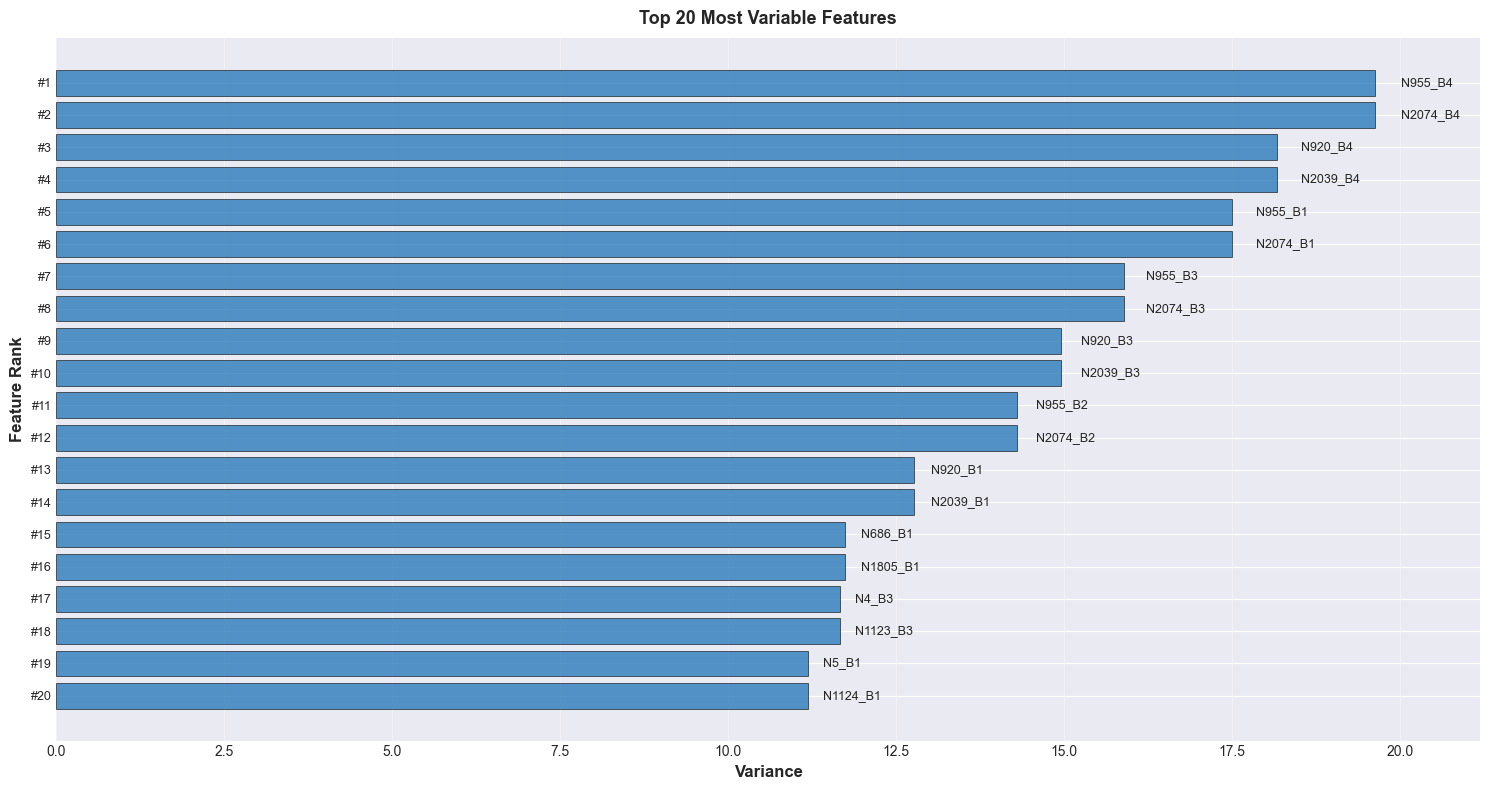

In [ ]:
# Most variable features visualization
fig, ax = plt.subplots(1, 1, figsize=(15, 8))

# Get colors from palette
colors = sns.color_palette()

top_20_for_plot = top_var_df.head(20)

bars = ax.barh(range(len(top_20_for_plot)), top_20_for_plot['Variance'], color=colors[4], 
               alpha=0.8, edgecolor='black', linewidth=0.5)

# Annotate with neuron and time bin info
for i, (idx, row) in enumerate(top_20_for_plot.iterrows()):
    ax.text(row['Variance'] * 1.02, i, 
            f"N{row['Neuron']}_B{row['Time_Bin']}", 
            va='center', fontsize=9)

ax.set_xlabel('Variance', fontsize=12, fontweight='bold')
ax.set_ylabel('Feature Rank', fontsize=12, fontweight='bold')
ax.set_title('Top 20 Most Variable Features', fontsize=13, fontweight='bold', pad=10)
ax.set_yticks(range(len(top_20_for_plot)))
ax.set_yticklabels([f'#{i+1}' for i in range(len(top_20_for_plot))], fontsize=9)
ax.set_xlim(0, top_20_for_plot['Variance'].max() * 1.08)
ax.invert_yaxis()
ax.grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

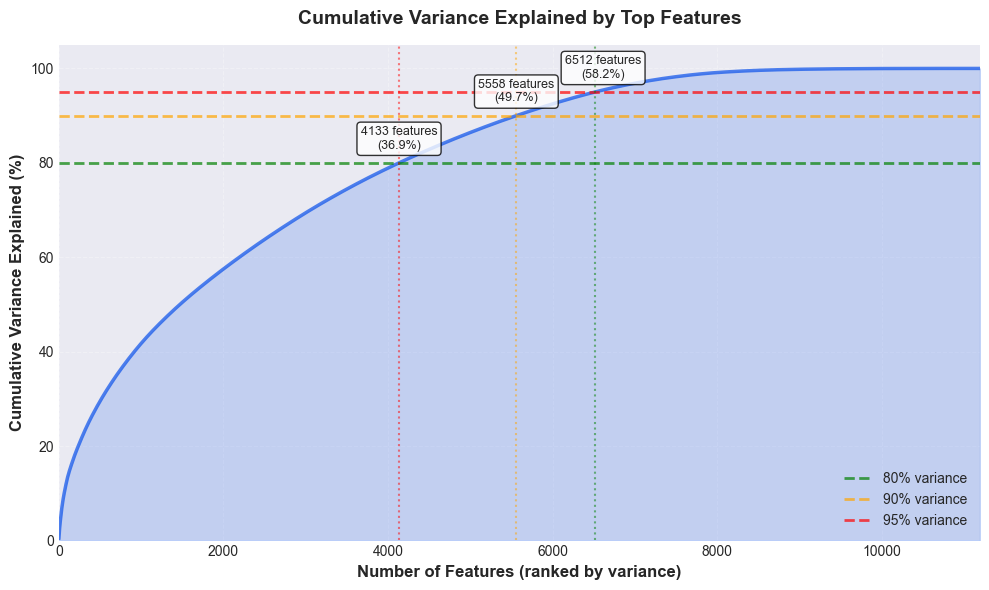

In [ ]:
# Cumulative Variance Explained by top variable features
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

sorted_variances = np.sort(feature_variances.values)[::-1]
cumulative_variance = np.cumsum(sorted_variances)
cumulative_variance_pct = cumulative_variance / cumulative_variance[-1] * 100

ax.plot(range(1, len(cumulative_variance_pct) + 1), cumulative_variance_pct,  linewidth=2.5, color='#2563eb', alpha=0.8)
ax.fill_between(range(1, len(cumulative_variance_pct) + 1), cumulative_variance_pct,  alpha=0.2, color='#2563eb')

ax.axhline(y=80, color='green', linestyle='--', linewidth=2, alpha=0.7, label='80% variance')
ax.axhline(y=90, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='90% variance')
ax.axhline(y=95, color='red', linestyle='--', linewidth=2, alpha=0.7, label='95% variance')
features_80 = np.argmax(cumulative_variance_pct >= 80) + 1
features_90 = np.argmax(cumulative_variance_pct >= 90) + 1
features_95 = np.argmax(cumulative_variance_pct >= 95) + 1

ax.axvline(x=features_80, color='red', linestyle=':', linewidth=1.5, alpha=0.5)
ax.axvline(x=features_90, color='orange', linestyle=':', linewidth=1.5, alpha=0.5)
ax.axvline(x=features_95, color='green', linestyle=':', linewidth=1.5, alpha=0.5)

ax.text(features_80, 83, f'{features_80} features\n({features_80/n_features*100:.1f}%)', fontsize=9, ha='center', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
ax.text(features_90, 93, f'{features_90} features\n({features_90/n_features*100:.1f}%)', fontsize=9, ha='center', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
ax.text(features_95 +100, 98, f'{features_95} features\n({features_95/n_features*100:.1f}%)', fontsize=9, ha='center', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax.set_xlabel('Number of Features (ranked by variance)', fontsize=12, fontweight='bold')
ax.set_ylabel('Cumulative Variance Explained (%)', fontsize=12, fontweight='bold')
ax.set_title('Cumulative Variance Explained by Top Features', fontsize=14, fontweight='bold', pad=15)
ax.set_xlim(0, min(11190, n_features))
ax.set_ylim(0, 105)
ax.legend(loc='lower right', fontsize=10)
ax.grid(alpha=0.3, linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

#### T2.1.5. Temporal Structure Analysis

In [78]:
# Extract time bin from feature names
def get_time_bin(feature_name):
    return int(feature_name.split('_')[-1])

# Group features by time bin
bin_columns = {i: [col for col in X.columns if get_time_bin(col) == i] 
               for i in range(n_bins)}

# Average activity per time bin
bin_activity = []
for bin_idx in range(n_bins):
    bin_cols = bin_columns[bin_idx]
    avg_activity = X[bin_cols].values.mean()
    std_activity = X[bin_cols].values.std()
    bin_activity.append({
        'Bin': f'{bin_idx*100}-{(bin_idx+1)*100}ms',
        'Bin_Num': bin_idx,
        'Avg_Activity': avg_activity,
        'Std_Activity': std_activity
    })

bin_activity_df = pd.DataFrame(bin_activity)
print("Average activity per time bin:")
print(bin_activity_df.to_string(index=False))

Average activity per time bin:
      Bin  Bin_Num  Avg_Activity  Std_Activity
  0-100ms        0      0.389098      0.859971
100-200ms        1      0.418032      0.907987
200-300ms        2      0.429206      0.912749
300-400ms        3      0.437148      0.924034
400-500ms        4      0.421962      0.918848


In [79]:
# Class-conditional temporal patterns
class_temporal = []
for bin_idx in range(n_bins):
    bin_cols = bin_columns[bin_idx]
    
    class_0_activity = X.loc[y == 0, bin_cols].values.mean()
    class_1_activity = X.loc[y == 1, bin_cols].values.mean()
    
    class_temporal.append({
        'Bin': f'{bin_idx*100}-{(bin_idx+1)*100}ms',
        'Bin_Num': bin_idx,
        'Left_0': class_0_activity,
        'Right_1': class_1_activity,
        'Difference': abs(class_0_activity - class_1_activity)
    })

class_temporal_df = pd.DataFrame(class_temporal)
print("\nClass-conditional temporal patterns:")
print(class_temporal_df.to_string(index=False))


Class-conditional temporal patterns:
      Bin  Bin_Num   Left_0  Right_1  Difference
  0-100ms        0 0.381217 0.392550    0.011333
100-200ms        1 0.406102 0.423256    0.017154
200-300ms        2 0.414931 0.435456    0.020526
300-400ms        3 0.421552 0.443977    0.022426
400-500ms        4 0.414570 0.425199    0.010629


In [80]:
# Identify most discriminative time bins
most_discriminative_bin = class_temporal_df.loc[class_temporal_df['Difference'].idxmax()]
print(f"\nMost discriminative time bin: {most_discriminative_bin['Bin']}")
print(f"  Difference: {most_discriminative_bin['Difference']:.4f}")


Most discriminative time bin: 300-400ms
  Difference: 0.0224


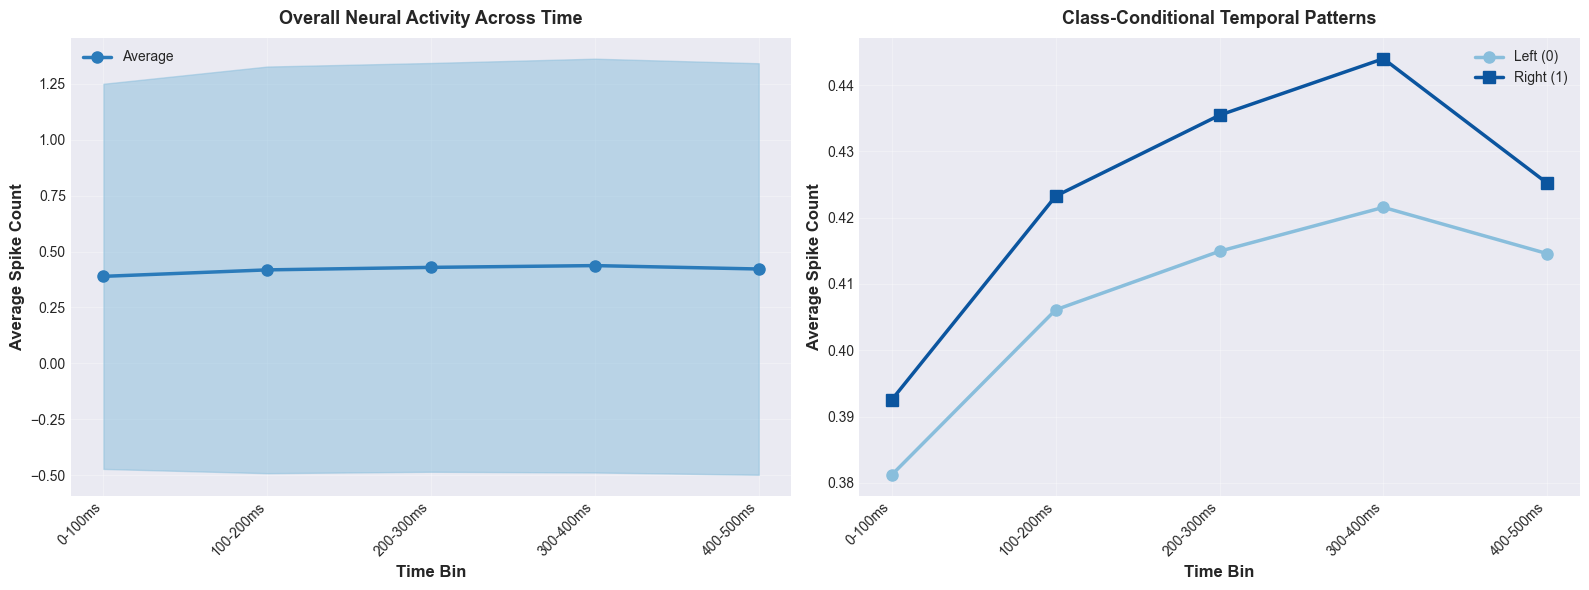

In [ ]:
 # Temporal pattern visualizations
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Overall activity
ax = axes[0]
ax.plot(bin_activity_df['Bin_Num'], bin_activity_df['Avg_Activity'], color = colors[4], marker='o', linewidth=2.5, markersize=8, label='Average')
ax.fill_between(bin_activity_df['Bin_Num'], bin_activity_df['Avg_Activity'] - bin_activity_df['Std_Activity'], bin_activity_df['Avg_Activity'] + bin_activity_df['Std_Activity'], color = colors[2], alpha=0.5)
ax.set_xlabel('Time Bin', fontsize=12, fontweight='bold')
ax.set_ylabel('Average Spike Count', fontsize=12, fontweight='bold')
ax.set_title('Overall Neural Activity Across Time', fontsize=13, fontweight='bold', pad=10)
ax.set_xticks(range(n_bins))
ax.set_xticklabels(bin_activity_df['Bin'], rotation=45, ha='right')
ax.grid(alpha=0.3)
ax.legend()

# Right: Class-conditional
ax = axes[1]
ax.plot(class_temporal_df['Bin_Num'], class_temporal_df['Left_0'],  marker='o', linewidth=2.5, markersize=8, color=colors[2], label='Left (0)')
ax.plot(class_temporal_df['Bin_Num'], class_temporal_df['Right_1'],  marker='s', linewidth=2.5, markersize=8, color=colors[5], label='Right (1)')
ax.set_xlabel('Time Bin', fontsize=12, fontweight='bold')
ax.set_ylabel('Average Spike Count', fontsize=12, fontweight='bold')
ax.set_title('Class-Conditional Temporal Patterns', fontsize=13, fontweight='bold', pad=10)
ax.set_xticks(range(n_bins))
ax.set_xticklabels(class_temporal_df['Bin'], rotation=45, ha='right')
ax.grid(alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

#### T2.1.6. Neuron-Level Analysis

In [83]:
# Extract unique neuron IDs from column names
neuron_ids = sorted(set(int(col.split('_')[1]) for col in X.columns if col.startswith('unit_')))

# For each neuron, calculate which time bin has peak activity
neuron_peak_bins = {}
neuron_total_activity = {}
neuron_stats = []  

for neuron_id in neuron_ids:
    neuron_cols = [col for col in X.columns if col.split('_')[1] == f'{neuron_id:04d}']
    
    if len(neuron_cols) > 0: # Get mean activity per time bin for this neuron
        bin_activities = []
        for bin_idx in range(n_bins):
            col_name = f'unit_{neuron_id:04d}_bin_{bin_idx}'
            if col_name in X.columns:
                bin_activities.append(X[col_name].mean())
            else:
                bin_activities.append(0)
        
        total_activity = sum(bin_activities)
        peak_bin = np.argmax(bin_activities)
        neuron_peak_bins[neuron_id] = peak_bin
        neuron_total_activity[neuron_id] = total_activity
        
        # Store detailed stats
        neuron_data = X[neuron_cols].values.flatten()
        neuron_stats.append({
            'Neuron_ID': neuron_id,
            'Avg_Activity': neuron_data.mean(),
            'Total_Activity': total_activity,
            'Peak_Bin': peak_bin,
            'Sparsity_%': (neuron_data == 0).sum() / len(neuron_data) * 100
        })

# Count neurons peaking at each time bin
peak_bin_counts = {i: 0 for i in range(n_bins)}
for peak_bin in neuron_peak_bins.values():
    peak_bin_counts[peak_bin] += 1

print(f"\nNeurons analyzed: {len(neuron_peak_bins)}")
print("\nTemporal response distribution:")
for bin_idx in range(n_bins):
    count = peak_bin_counts[bin_idx]
    pct = count / len(neuron_peak_bins) * 100 if len(neuron_peak_bins) > 0 else 0
    print(f"  Bin {bin_idx} ({bin_idx*100}-{(bin_idx+1)*100}ms): {count} neurons ({pct:.1f}%)")

# Identify neurons with different temporal preferences
early_responders = [nid for nid, peak in neuron_peak_bins.items() if peak in [0, 1]]
late_responders = [nid for nid, peak in neuron_peak_bins.items() if peak in [3, 4]]

print(f"\nTemporal specialization:")
print(f"  Early responders (0-200ms): {len(early_responders)} neurons")
print(f"  Late responders (300-500ms): {len(late_responders)} neurons")


Neurons analyzed: 2238

Temporal response distribution:
  Bin 0 (0-100ms): 314 neurons (14.0%)
  Bin 1 (100-200ms): 404 neurons (18.1%)
  Bin 2 (200-300ms): 456 neurons (20.4%)
  Bin 3 (300-400ms): 662 neurons (29.6%)
  Bin 4 (400-500ms): 402 neurons (18.0%)

Temporal specialization:
  Early responders (0-200ms): 718 neurons
  Late responders (300-500ms): 1064 neurons


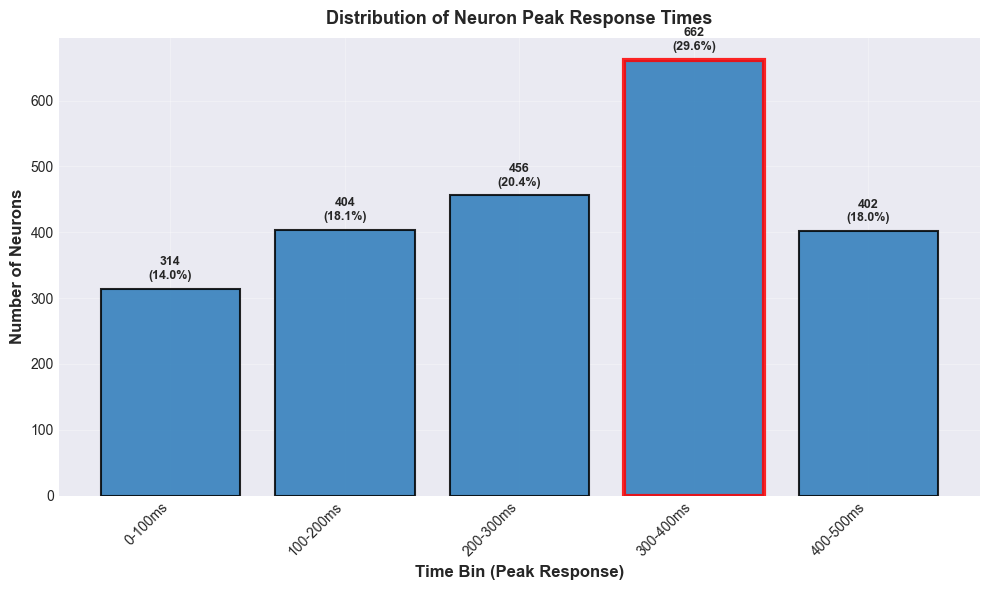

In [ ]:
# Peak response time distribution visualization
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

bins_labels = [f'{i*100}-{(i+1)*100}ms' for i in range(n_bins)]
counts = [peak_bin_counts[i] for i in range(n_bins)]

bar_color = colors[4]
edge_color = 'black'

bars = ax.bar(range(n_bins), counts, color=bar_color, alpha=0.85, edgecolor=edge_color, linewidth=1.5)

max_idx = counts.index(max(counts))
bars[max_idx].set_edgecolor("red")
bars[max_idx].set_linewidth(3)

ax.set_xlabel('Time Bin (Peak Response)', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Neurons', fontsize=12, fontweight='bold')
ax.set_title('Distribution of Neuron Peak Response Times', fontsize=13, fontweight='bold', pad=10)
ax.set_xticks(range(n_bins))
ax.set_xticklabels(bins_labels, rotation=45, ha='right')
ax.grid(alpha=0.3)
 
for i, (bar, count) in enumerate(zip(bars, counts)):
    height = bar.get_height()
    pct = count / sum(counts) * 100 if sum(counts) > 0 else 0
    ax.text(bar.get_x() + bar.get_width()/2., height + max(counts) * 0.015, f'{count}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

In [85]:
neuron_stats_df = pd.DataFrame(neuron_stats)

if len(neuron_stats_df) >= 10:
    top_neurons = neuron_stats_df.nlargest(10, 'Avg_Activity')
    print(f"\nTop 10 most active neurons:")
    print(top_neurons.to_string(index=False))
else:
    print(f"\nMost active neurons:")
    print(neuron_stats_df.nlargest(len(neuron_stats_df), 'Avg_Activity').to_string(index=False))


Top 10 most active neurons:
 Neuron_ID  Avg_Activity  Total_Activity  Peak_Bin  Sparsity_%
        68      4.774231       23.871157         4    1.727672
      1187      4.774231       23.871157         4    1.727672
         1      3.038653       15.193265         2    7.086384
      1120      3.038653       15.193265         2    7.086384
       955      2.904832       14.524158         4   43.162518
      2074      2.904832       14.524158         4   43.162518
        32      2.773646       13.868228         0    7.701318
      1151      2.773646       13.868228         0    7.701318
       942      2.694290       13.471449         4   32.093704
      2061      2.694290       13.471449         4   32.093704
